In [ ]:
from utils import *
from cyclegan import *

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import clear_output

from torch.utils.data import Dataset
from PIL import Image

##############################################
# Residual block with two convolution layers.
##############################################

class ResidualBlock(nn.Module):
    def __init__(self, in_channel):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1), # Gives better quality of Images.
            nn.Conv2d(in_channel, in_channel, 3),
            nn.InstanceNorm2d(in_channel),
            nn.ReLU(inplace=True),

            nn.ReplicationPad2d(1),
            nn.Conv2d(in_channel, in_channel, 3),
            nn.InstanceNorm2d(in_channel)
        )

    def forward(self, x):
        return x + self.block(x)

##############################################
# Generator
##############################################

""" As per Paper -- Generator with 9 residual blocks consists of:
c7s1-64,d128,d256,R256,R256,R256, R256,R256,R256,R256,R256,R256,
u128, u64,c7s1-3
"""

class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_blocks):
        super(GeneratorResNet, self).__init__()

        channels = input_shape[0]

        # Initial convolution block
        out_channels = 64

        model =  [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_channels, kernel_size=7),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True),
        ]
        in_channels = out_channels

        # Downsampling
        # d128 => d256
        for _ in range(2):
            out_channels *= 2
            model += [
                nn.Conv2d(
                    in_channels, out_channels, kernel_size=3,  stride=2, padding=1
                ),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
            in_channels = out_channels

        """ Residual blocks - Per Paper
        R256,R256,R256,R256,R256,R256,R256,R256,R256
        """
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_channels)]


        #Upsampling
        for _ in range(2):
            out_channels //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
            in_channels = out_channels

        # Output layer
        # c7s1-3
        model += [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(out_channels, channels, 7),
            nn.Tanh(),
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


##############################
#        Discriminator
##############################
""" We use 70 × 70 PatchGAN.

Let Ck denote a 4 × 4 Convolution-InstanceNorm-LeakyReLU layer with k filters and stride 2.

After the last layer, we apply a convolution to produce a 1-dimensional output.

We do not use InstanceNorm for the first C64 layer.

We use leaky ReLUs with a slope of 0.2. The discriminator architecture is:" C64-C128-C256-C512 """


class Discriminator(nn.Module):

    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        channels, height, width = input_shape

        # Calculate output shape of image discriminator (PatchGAN)
        # If the input shape is (channels, height, width) = (3, 256, 256): Then the output_shape will be (1,16,16)
        self.output_shape = (1, height // 2 ** 4, width // 2 ** 4)

        def discriminator_block(in_channels, out_channels, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [
                nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
            ]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        # C64 -> C128 -> C256 -> C512
        self.model = nn.Sequential(
            *discriminator_block(channels, out_channels=64, normalize=False),
            *discriminator_block(64, out_channels=128),
            *discriminator_block(128, out_channels=256),
            *discriminator_block(256, out_channels=512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, padding=1)
        )

    def forward(self, img):
        return self.model(img)

batches_done  0


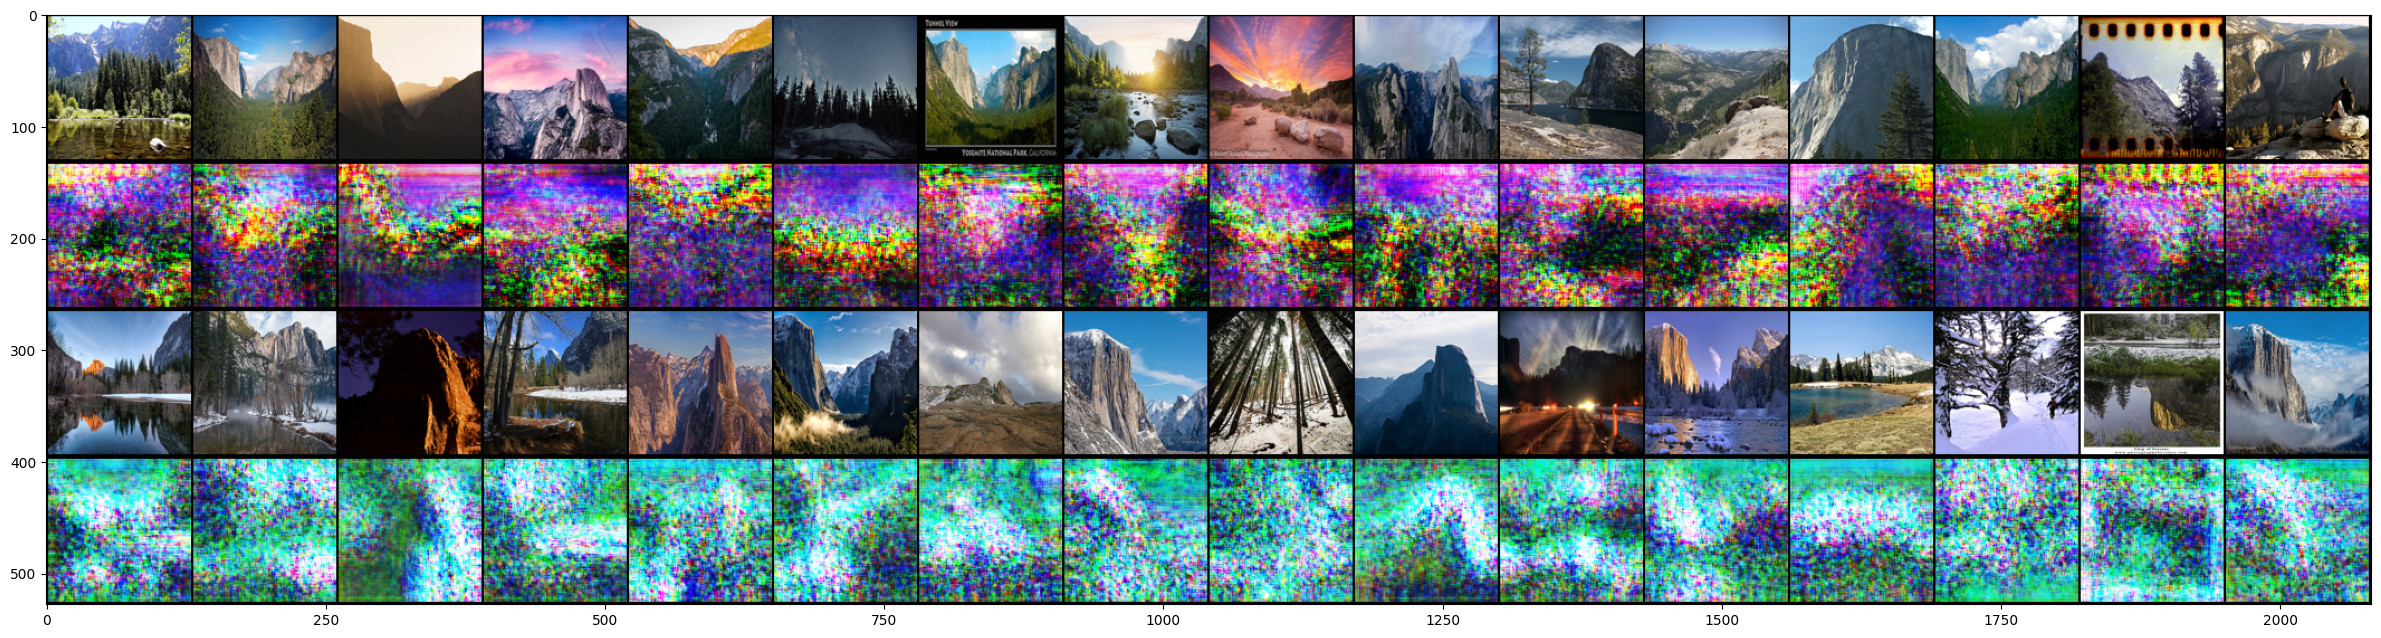

[Epoch 0/200] [Batch 1/308] [D loss: 2.327025] [G loss: 10.465015, adv: 2.133586, cycle: 0.563977, identity: 0.538332] ETA: 22 days, 16:24:01.816491
[Epoch 0/200] [Batch 2/308] [D loss: 2.856744] [G loss: 11.777030, adv: 2.501882, cycle: 0.648705, identity: 0.557619] ETA: 8 days, 0:40:12.204200
[Epoch 0/200] [Batch 3/308] [D loss: 2.442966] [G loss: 9.719263, adv: 1.925582, cycle: 0.526765, identity: 0.505205] ETA: 7 days, 20:28:31.786024
[Epoch 0/200] [Batch 4/308] [D loss: 1.722054] [G loss: 9.134459, adv: 1.557808, cycle: 0.516732, identity: 0.481866] ETA: 7 days, 19:32:17.423464
[Epoch 0/200] [Batch 5/308] [D loss: 1.228824] [G loss: 7.218407, adv: 1.168867, cycle: 0.413492, identity: 0.382923] ETA: 7 days, 13:20:53.128107
[Epoch 0/200] [Batch 6/308] [D loss: 1.195687] [G loss: 6.496550, adv: 1.214564, cycle: 0.357777, identity: 0.340843] ETA: 7 days, 19:29:47.285915
[Epoch 0/200] [Batch 7/308] [D loss: 1.266636] [G loss: 7.389782, adv: 1.444977, cycle: 0.404061, identity: 0.380838

KeyboardInterrupt: 

In [ ]:
import numpy as np
import itertools
import time
import datetime
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
from matplotlib.pyplot import figure
from IPython.display import clear_output
from PIL import Image
import matplotlib.image as mpimg

from utils import *


# Check if CUDA is available
cuda = torch.cuda.is_available()
print("Using CUDA" if cuda else "Not using CUDA")

# Set Tensor type based on CUDA availability
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# Define hyperparameters
class Hyperparameters:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

hp = Hyperparameters(
    epoch=0,
    n_epochs=200,
    dataset_train_mode="train",
    dataset_test_mode="test",
    batch_size=4,
    lr=0.0002,
    decay_start_epoch=100,
    b1=0.5,
    b2=0.999,
    n_cpu=8,
    img_size=128,
    channels=3,
    n_critic=5,
    sample_interval=100,
    num_residual_blocks=99,
    lambda_cyc=10.0,
    lambda_id=5.0,
)

# Root path for datasets
root_path = "/content/drive/MyDrive/archive"

# Define image visualization methods
def show_img(img, size=10):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(size, size))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def to_img(x):
    x = x.view(x.size(0) * 2, hp.channels, hp.img_size, hp.img_size)
    return x

def plot_output(path, x, y):
    img = mpimg.imread(path)
    plt.figure(figsize=(x, y))
    plt.imshow(img)
    plt.show()

# Define image transforms
transforms_ = [
    transforms.Resize((hp.img_size, hp.img_size), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

# Load datasets
train_dataloader = DataLoader(
    ImageDataset(root_path, mode=hp.dataset_train_mode, transforms_=transforms_),
    batch_size=hp.batch_size,
    shuffle=True,
    num_workers=1,
)
val_dataloader = DataLoader(
    ImageDataset(root_path, mode=hp.dataset_test_mode, transforms_=transforms_),
    batch_size=16,
    shuffle=True,
    num_workers=1,
)

# Function to save image samples
def save_img_samples(batches_done):
    print("batches_done ", batches_done)
    imgs = next(iter(val_dataloader))

    Gen_AB.eval()
    Gen_BA.eval()

    real_A = imgs["A"].type(Tensor)
    fake_B = Gen_AB(real_A)
    real_B = imgs["B"].type(Tensor)
    fake_A = Gen_BA(real_B)

    real_A = make_grid(real_A, nrow=16, normalize=True)
    real_B = make_grid(real_B, nrow=16, normalize=True)
    fake_A = make_grid(fake_A, nrow=16, normalize=True)
    fake_B = make_grid(fake_B, nrow=16, normalize=True)

    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    path = root_path + "/%s.png" % (batches_done)
    save_image(image_grid, path, normalize=False)
    return path

# Loss functions
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

input_shape = (hp.channels, hp.img_size, hp.img_size)

# Initialize generator and discriminator
Gen_AB = GeneratorResNet(input_shape, hp.num_residual_blocks)
Gen_BA = GeneratorResNet(input_shape, hp.num_residual_blocks)
Disc_A = Discriminator(input_shape)
Disc_B = Discriminator(input_shape)

if cuda:
    Gen_AB = Gen_AB.cuda()
    Gen_BA = Gen_BA.cuda()
    Disc_A = Disc_A.cuda()
    Disc_B = Disc_B.cuda()
    criterion_GAN.cuda()
    criterion_cycle.cuda()
    criterion_identity.cuda()

# Initialize weights
Gen_AB.apply(initialize_conv_weights_normal)
Gen_BA.apply(initialize_conv_weights_normal)
Disc_A.apply(initialize_conv_weights_normal)
Disc_B.apply(initialize_conv_weights_normal)

# Buffers for previously generated samples
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

# Optimizers
optimizer_G = torch.optim.Adam(
    itertools.chain(Gen_AB.parameters(), Gen_BA.parameters()),
    lr=hp.lr,
    betas=(hp.b1, hp.b2),
)
optimizer_Disc_A = torch.optim.Adam(Disc_A.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))
optimizer_Disc_B = torch.optim.Adam(Disc_B.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))

# Learning rate schedulers
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G, lr_lambda=LambdaLR(hp.n_epochs, hp.epoch, hp.decay_start_epoch).step
)
lr_scheduler_Disc_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_Disc_A, lr_lambda=LambdaLR(hp.n_epochs, hp.epoch, hp.decay_start_epoch).step
)
lr_scheduler_Disc_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_Disc_B, lr_lambda=LambdaLR(hp.n_epochs, hp.epoch, hp.decay_start_epoch).step
)

# Training function
def train(
    Gen_BA,
    Gen_AB,
    Disc_A,
    Disc_B,
    train_dataloader,
    n_epochs,
    criterion_identity,
    criterion_cycle,
    lambda_cyc,
    criterion_GAN,
    optimizer_G,
    fake_A_buffer,
    fake_B_buffer,
    clear_output,
    optimizer_Disc_A,
    optimizer_Disc_B,
    Tensor,
    sample_interval,
    lambda_id,
):
    prev_time = time.time()
    for epoch in range(hp.epoch, n_epochs):
        for i, batch in enumerate(train_dataloader):
            real_A = batch["A"].type(Tensor)
            real_B = batch["B"].type(Tensor)

            valid = torch.ones((real_A.size(0), *Disc_A.output_shape), requires_grad=False).type(Tensor)
            fake = torch.zeros((real_A.size(0), *Disc_A.output_shape), requires_grad=False).type(Tensor)

            #########################
            #  Train Generators
            #########################

            Gen_AB.train()  # Horses are converted to Zebras(Fake)
            Gen_BA.train()  # Zebras are converted to Horses(Fake)

            optimizer_G.zero_grad()

            # Identity Loss
            # First pass real A images to the Generator, that will generate A-domain images
            loss_id_A = criterion_identity(Gen_BA(real_A), real_A)
            # Then pass real B images to the Generator, that will generate B-domain images
            loss_id_B = criterion_identity(Gen_AB(real_B), real_B)
            loss_identity = (loss_id_A + loss_id_B) / 2

            # GAN losses for GAN_AB
            fake_B = Gen_AB(real_A)   # Gen_AB is generating fake B from real A images (horse to zebra)
            loss_GAN_AB = criterion_GAN(Disc_B(fake_B), valid)

            # GAN losses for GAN_BA
            fake_A = Gen_BA(real_B)  # Gen_BA is generating fake A from real B images (zebra to horse)
            loss_GAN_BA = criterion_GAN(Disc_A(fake_A), valid)
            loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

            # Cycle Consistency Loss
            reconstructed_A = Gen_BA(fake_B) # Here the fake zebra is being converted back to horse using Gen_BA
            loss_cycle_A = criterion_cycle(reconstructed_A, real_A) # Forward loss
            reconstructed_B = Gen_AB(fake_A) # Here the fake horse is being converted back zebra using Gen_AB
            loss_cycle_B = criterion_cycle(reconstructed_B, real_B) # Backward loss
            loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

            loss_G = loss_GAN + lambda_cyc * loss_cycle + lambda_id * loss_identity
            loss_G.backward()
            """
            Now we just need to update all the parameters!
            Θ_{k+1} = Θ_k - η * ∇_Θ ℓ(y_hat, y)
            """
            optimizer_G.step()

            #########################
            #  Train Discriminator A
            #########################
            optimizer_Disc_A.zero_grad()

            # Real loss
            loss_real = criterion_GAN(Disc_A(real_A), valid)
            fake_A_ = fake_A_buffer.push_and_pop(fake_A)
            loss_fake = criterion_GAN(Disc_A(fake_A_.detach()), fake)
            loss_Disc_A = (loss_real + loss_fake) / 2
            loss_Disc_A.backward()
            optimizer_Disc_A.step()

            #########################
            #  Train Discriminator B
            #########################
            optimizer_Disc_B.zero_grad()
            loss_real = criterion_GAN(Disc_B(real_B), valid)
            fake_B_ = fake_B_buffer.push_and_pop(fake_B)
            loss_fake = criterion_GAN(Disc_B(fake_B_.detach()), fake)
            loss_Disc_B = (loss_real + loss_fake) / 2
            loss_Disc_B.backward()
            optimizer_Disc_B.step()

            loss_D = (loss_Disc_A + loss_Disc_B) / 2

            batches_done = epoch * len(train_dataloader) + i
            batches_left = n_epochs * len(train_dataloader) - batches_done
            time_left = datetime.timedelta(
                seconds=batches_left * (time.time() - prev_time)
            )
            prev_time = time.time()

            print(
                "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, adv: %f, cycle: %f, identity: %f] ETA: %s"
                % (
                    epoch,
                    n_epochs,
                    i,
                    len(train_dataloader),
                    loss_D.item(),
                    loss_G.item(),
                    loss_GAN.item(),
                    loss_cycle.item(),
                    loss_identity.item(),
                    time_left,
                )
            )

            if batches_done % sample_interval == 0:
                clear_output()
                plot_output(save_img_samples(batches_done), 30, 40)

# Execute the final training function
train(
    Gen_BA=Gen_BA,
    Gen_AB=Gen_AB,
    Disc_A=Disc_A,
    Disc_B=Disc_B,
    train_dataloader=train_dataloader,
    n_epochs=hp.n_epochs,
    criterion_identity=criterion_identity,
    criterion_cycle=criterion_cycle,
    lambda_cyc=hp.lambda_cyc,
    criterion_GAN=criterion_GAN,
    optimizer_G=optimizer_G,
    fake_A_buffer=fake_A_buffer,
    fake_B_buffer=fake_B_buffer,
    clear_output=clear_output,
    optimizer_Disc_A=optimizer_Disc_A,
    optimizer_Disc_B=optimizer_Disc_B,
    Tensor=Tensor,
    sample_interval=hp.sample_interval,
    lambda_id=hp.lambda_id,
)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
2*3

6